# Rotation matrix for spherical harmonics

In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

from IPython.display import display, Math
import sympy
from sympy import *
from sympy.functions.special.tensor_functions import KroneckerDelta

starry.config.quiet = True
np.random.seed(1)

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Define our symbols
l, m, n, alpha, beta, gamma, u1, u2, u3, theta = symbols('l m n alpha beta gamma u1 u2 u3 theta')

In [4]:
def Dmn(l, m, n, alpha, beta, gamma):
    """Compute the (m, n) term of the Wigner D matrix."""
    sumterm = 0
    # Expression diverges when beta = 0
    if beta == 0:
        beta = 1e-16
    for k in range(l + m + 1):
        sumterm += (-1) ** k * cos(beta / 2) ** (2 * l + m - n - 2 * k) * \
                   sin(beta / 2) ** (-m + n + 2 * k) / \
                   (factorial(k) * factorial(l + m - k) * factorial(l - n - k) * factorial(n - m + k))
    return sumterm * exp(-I * (alpha * n + gamma * m)) * (-1) ** (n + m) * \
           sqrt(factorial(l - m) * factorial(l + m) * factorial(l - n) * factorial(l + n))

In [5]:
def D(l, alpha, beta, gamma):
    """Compute the Wigner D matrix."""
    res = zeros(2 * l + 1, 2 * l + 1)
    for m in range(-l, l + 1):
        for n in range(-l, l + 1):
            res[m + l, n + l] = Dmn(l, m, n, alpha, beta, gamma)
    return res

# Print it for l = 1
D(1, alpha, beta, gamma)

Matrix([
[     1.0*exp(-I*(-alpha - gamma))*cos(beta/2)**2, -1.0*sqrt(2)*exp(I*gamma)*sin(beta/2)*cos(beta/2),         exp(-I*(alpha - gamma))*sin(beta/2)**2],
[1.0*sqrt(2)*exp(I*alpha)*sin(beta/2)*cos(beta/2),                  -sin(beta/2)**2 + cos(beta/2)**2, -sqrt(2)*exp(-I*alpha)*sin(beta/2)*cos(beta/2)],
[         exp(-I*(-alpha + gamma))*sin(beta/2)**2,     sqrt(2)*exp(-I*gamma)*sin(beta/2)*cos(beta/2),         exp(-I*(alpha + gamma))*cos(beta/2)**2]])

In [6]:
def Umn(l, m, n):
    """Compute the (m, n) term of the transformation matrix from complex to real Ylms."""
    if n < 0:
        term1 = I
    elif n == 0:
        term1 = sqrt(2) / 2
    else:
        term1 = 1
    if (m > 0) and (n < 0) and (n % 2 == 0):
        term2 = -1
    elif (m > 0) and (n > 0) and (n % 2 != 0):
        term2 = -1
    else:
        term2 = 1
    return term1 * term2 * 1 / sqrt(2) * (KroneckerDelta(m, n) + KroneckerDelta(m, -n))

In [7]:
def U(l):
    """Compute the U transformation matrix."""
    res = zeros(2 * l + 1, 2 * l + 1)
    for m in range(-l, l + 1):
        for n in range(-l, l + 1):
            res[m + l, n+ l] = Umn(l, m, n)
    return res

# Print it for l = 1
U(1)

Matrix([
[sqrt(2)*I/2, 0,  sqrt(2)/2],
[          0, 1,          0],
[sqrt(2)*I/2, 0, -sqrt(2)/2]])

In [8]:
def REuler(l, alpha, beta, gamma):
    """Return the rotation matrix for a single degree `l`."""
    res = zeros(2 * l + 1, 2 * l + 1)
    if l == 0:
        res[0, 0] = 1
        return res
    foo = re(U(l).inv() * D(l, alpha, beta, gamma) * U(l))
    for m in range(2 * l + 1):
        for n in range(2 * l + 1):
            if abs(foo[m, n]) < 1e-15:
                res[m, n] = 0
            else:
                res[m, n] = foo[m, n]
    return res

To make things easier to visualize, let's convert our rotation matrix to the axis-angle formalism.

In [9]:
def RAxisAngle(l, u1, u2, u3, theta):
    """Axis-angle rotation matrix."""
    # Numerical tolerance
    tol = 1e-16
    if theta == 0:
        theta = tol
    if u1 == 0 and u2 == 0:
        u1 = tol
        u2 = tol
        
    # Elements of the transformation matrix
    costheta = cos(theta)
    sintheta = sin(theta)
    RA01 = u1 * u2 * (1 - costheta) - u3 * sintheta
    RA02 = u1 * u3 * (1 - costheta) + u2 * sintheta
    RA11 = costheta + u2 * u2 * (1 - costheta)
    RA12 = u2 * u3 * (1 - costheta) - u1 * sintheta
    RA20 = u3 * u1 * (1 - costheta) - u2 * sintheta
    RA21 = u3 * u2 * (1 - costheta) + u1 * sintheta
    RA22 = costheta + u3 * u3 * (1 - costheta)

    # Determine the Euler angles
    if ((RA22 < -1 + tol) and (RA22 > -1 - tol)):
        cosbeta = -1
        sinbeta = 0
        cosgamma = RA11
        singamma = RA01
        cosalpha = 1
        sinalpha = 0
    elif ((RA22 < 1 + tol) and (RA22 > 1 - tol)):
        cosbeta = 1
        sinbeta = 0
        cosgamma = RA11
        singamma = -RA01
        cosalpha = 1
        sinalpha = 0
    else:
        cosbeta = RA22
        sinbeta = sqrt(1 - cosbeta ** 2)
        norm1 = sqrt(RA20 * RA20 + RA21 * RA21)
        norm2 = sqrt(RA02 * RA02 + RA12 * RA12)
        cosgamma = -RA20 / norm1
        singamma = RA21 / norm1
        cosalpha = RA02 / norm2
        sinalpha = RA12 / norm2
    alpha = atan2(sinalpha, cosalpha)
    beta = atan2(sinbeta, cosbeta)
    gamma = atan2(singamma, cosgamma)
    
    return REuler(l, alpha, beta, gamma)

Finally, note that `RAxisAngle` is the rotation matrix for a single degree `l`. To get the full rotation matrix, we construct it as a block diagonal matrix with the matrices for each `l` along the diagonal: 

In [10]:
def R(lmax, u1, u2, u3, theta):
    """Return the full axis-angle rotation matrix up to degree `lmax`."""
    blocks = [RAxisAngle(l, u1, u2, u3, theta) for l in range(lmax + 1)]
    return BlockDiagMatrix(*blocks)

In [11]:
Matrix(R(2, 1, 0, 0, np.pi/2))

Matrix([
[1,   0,    0,   0,   0,    0,            0,    0,            0],
[0,   0, -1.0,   0,   0,    0,            0,    0,            0],
[0, 1.0,    0,   0,   0,    0,            0,    0,            0],
[0,   0,    0, 1.0,   0,    0,            0,    0,            0],
[0,   0,    0,   0,   0,    0,            0, -1.0,            0],
[0,   0,    0,   0,   0, -1.0,            0,    0,            0],
[0,   0,    0,   0,   0,    0,         -0.5,    0, -0.5*sqrt(3)],
[0,   0,    0,   0, 1.0,    0,            0,    0,            0],
[0,   0,    0,   0,   0,    0, -0.5*sqrt(3),    0,          0.5]])

In [37]:
def Omega(R_func, theta, dtheta):
    """Calculate the matrix Ω for a given rotation matrix R(θ)."""
    R_theta = R_func(theta)
    R_theta_dtheta = R_func(theta + dtheta)
    
    Omega = (R_theta_dtheta - R_theta) / dtheta
    return Omega

lmax =3
u1 = 0
u2 = 0
u3 = 1
theta = np.pi / 2

dtheta = np.pi / 4  # Small angle increment for finite difference
Om = np.array(Omega(lambda t: R(lmax, u1, u2, u3, t), theta, dtheta))


In [38]:
Matrix(Omega(lambda t: R(lmax, u1, u2, u3, t), theta, dtheta))

Matrix([
[0,                  0, 0,                  0,                0,                  0, 0,                  0,                 0,                 0,                0,                  0, 0,                  0,                 0,                 0],
[0, -0.900316316157106, 0, -0.372923228578057,                0,                  0, 0,                  0,                 0,                 0,                0,                  0, 0,                  0,                 0,                 0],
[0,                  0, 0,                  0,                0,                  0, 0,                  0,                 0,                 0,                0,                  0, 0,                  0,                 0,                 0],
[0,  0.372923228578057, 0, -0.900316316157106,                0,                  0, 0,                  0,                 0,                 0,                0,                  0, 0,                  0,                 0,                 0],
[0,    

In [39]:
Matrix(np.identity((lmax+1)**2) + dtheta * Om) @ np.array(R(lmax, u1, u2, u3, theta))

Matrix([
[1.0,                  0,   0,                 0,    0,                  0,   0,                 0,    0,                0,    0,                  0,   0,                 0,    0,                 0],
[  0,  0.292893218813453,   0, 0.292893218813452,    0,                  0,   0,                 0,    0,                0,    0,                  0,   0,                 0,    0,                 0],
[  0,                  0, 1.0,                 0,    0,                  0,   0,                 0,    0,                0,    0,                  0,   0,                 0,    0,                 0],
[  0, -0.292893218813452,   0, 0.292893218813453,    0,                  0,   0,                 0,    0,                0,    0,                  0,   0,                 0,    0,                 0],
[  0,                  0,   0,                 0, -2.0,                  0,   0,                 0,  1.0,                0,    0,                  0,   0,                 0,    0,            

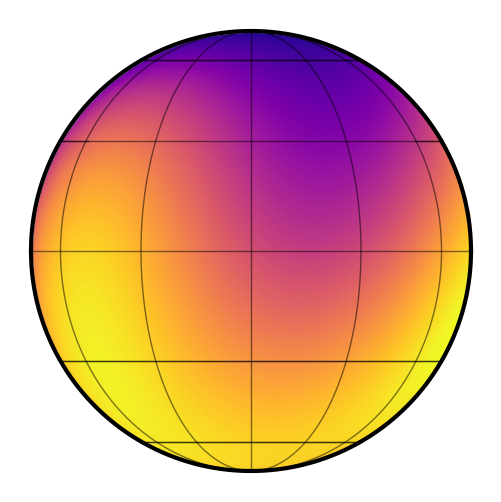

In [40]:
map = starry.Map(lmax)
map.load('spot')
map.amp = 1
map.show()

In [41]:
y = map.y
yrot = (np.identity((lmax+1)**2) + dtheta * Om) @ np.array(R(lmax, u1, u2, u3, theta)) @ y

In [42]:
yrot = yrot.astype('float64')

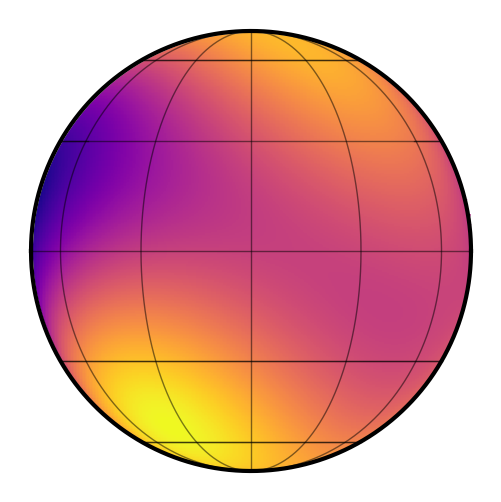

In [43]:
starry.config.lazy = False
map[:,:] = np.array(yrot[:])
map.show()